In [ ]:
Fragen:

    

# Bat Orientaion Calls - Classification with CNN



## General Preparations

Getting started with tensorflow on Mac M1:
https://github.com/jeffheaton/t81_558_deep_learning/blob/master/install/tensorflow-install-mac-metal-jul-2021.ipynb

activate environment
`conda activate apple_tensorflow`

deactivate  environment
`conda deactivate`

start jupyter
`jupyter notebook`

In [229]:
from matplotlib import image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn as sk
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pathlib
import shutil
import os
import cv2
import sys
import tensorflow as tf
import itertools
import math

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import keras_tuner as kt

In [230]:
print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {tf.keras.__version__}")
print(f"Keras Tuner Version: {kt.__version__}")
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")

Tensor Flow Version: 2.9.2
Keras Version: 2.9.0
Keras Tuner Version: 1.1.2
Python 3.9.13 | packaged by conda-forge | (main, May 27 2022, 17:00:33) 
[Clang 13.0.1 ]
Pandas 1.4.2
Scikit-Learn 1.1.1
GPU is available


We have to reanrage the given data to a new folder structure to use `image_dataset_from_directory`:

- images
   - class1
        - *.png
   - class2
        - *.png
   ...
   
and crop the x-Axis and y-Axis from the images.

In [231]:
df = pd.read_csv("LMU_20180326_class.csv", header=0, delimiter=';')
shutil.unpack_archive("LMU_20180326_png.zip", "")

for index, row in df.iterrows():
    folder = row['Species']
    filename = row['Filename'].replace('.jpg', '.png')
    
    if not os.path.exists(f'LMU_20180326_png_sorted/{folder}'):
        os.makedirs(f'LMU_20180326_png_sorted/{folder}')
    
    if os.path.exists(f'LMU_20180326_png/{filename}'):
        img = cv2.imread(f'LMU_20180326_png/{filename}')
        crop_img = img[36:252, 55:389]
        cv2.imwrite(f'LMU_20180326_png_sorted/{folder}/{filename}', crop_img)
 

df_old = pd.read_csv("Auswertung_20220524.csv", header=0, delimiter=';')
shutil.unpack_archive("2_LMU_20180326_png.zip", "LMU_20180326_png")

for index, row in df_old.iterrows():
    folder = row['Species']
    filename = row['Filename'].replace('.jpg', '.png')
    
    if not os.path.exists(f'LMU_20180326_png_sorted/{folder}'):
        os.makedirs(f'LMU_20180326_png_sorted/{folder}')
    
    if os.path.exists(f'LMU_20180326_png/{filename}'):
        img = cv2.imread(f'LMU_20180326_png/{filename}')
        crop_img = img[36:252, 55:389]
        cv2.imwrite(f'LMU_20180326_png_sorted/{folder}/{filename}', crop_img)

Delete the class **Große Hufeisennase** because only 3 images are assigned to this class.

In [233]:
shutil.rmtree('LMU_20180326_png_sorted/Große Hufeisennase/')

## Global Functions for Plots

In [234]:
def plot_confusion_matrix(cm, classes):
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20,10), sharex=True, sharey=True)
    
    ax1.title.set_text('Absolut')
    ax2.title.set_text('Relative')
    fig.text(0.5, 0, 'Predicated Label', ha='center')
    fig.text(0, 0.5, 'True label', va='center', rotation='vertical')

    cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
      
    sns.heatmap(cm, annot=True, xticklabels=classes, yticklabels=classes, ax=ax1, cmap="YlGnBu")
    sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=classes, yticklabels=classes, ax=ax2, cmap="YlGnBu")
    
    plt.tight_layout()
    plt.show()

In [235]:
def plot_model_loss_acc(epochs_range, acc, val_acc, loss, val_loss):
    plt.figure(figsize=(15, 10))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy', marker='o')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy', marker='o')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss', marker='o')
    plt.plot(epochs_range, val_loss, label='Validation Loss', marker='o')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

## Data Preparation

In [260]:
data_dir = pathlib.Path("LMU_20180326_png_sorted")
image_count = len(list(data_dir.glob('*/*.png')))
print(f"Found {image_count} images")

Found 1668 images


In [261]:
bat_filename = df["Filename"][0]
bat_species = df["Species"][0]
bat_image = image.imread(f'LMU_20180326_png_sorted/{bat_species}/{bat_filename.replace(".jpg", ".png")}')
img_height, img_width, img_channels = bat_image.shape
batch_size = 64
print(f"Bat image shape: {bat_image.shape}")

Bat image shape: (216, 334, 3)


Create training and validation data sets with keras `image_dataset_from_directory`. We are using 80% for training and 20% for validation.

In [262]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  label_mode='categorical',
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  label_mode='categorical',
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1668 files belonging to 8 classes.
Using 1335 files for training.
Found 1668 files belonging to 8 classes.
Using 333 files for validation.


We can access the different `class_names` of the data set:

In [263]:
class_names = train_ds.class_names
print(class_names)

['Bartfledermaus', 'Bechsteinfledermaus', 'Fledermaus nicht bestimmbar', 'Fransenfledermaus', 'Langohrfledermaus', 'Mausohr', 'Schwarzbild', 'Wasserfledermaus']


## Overview

### Plot

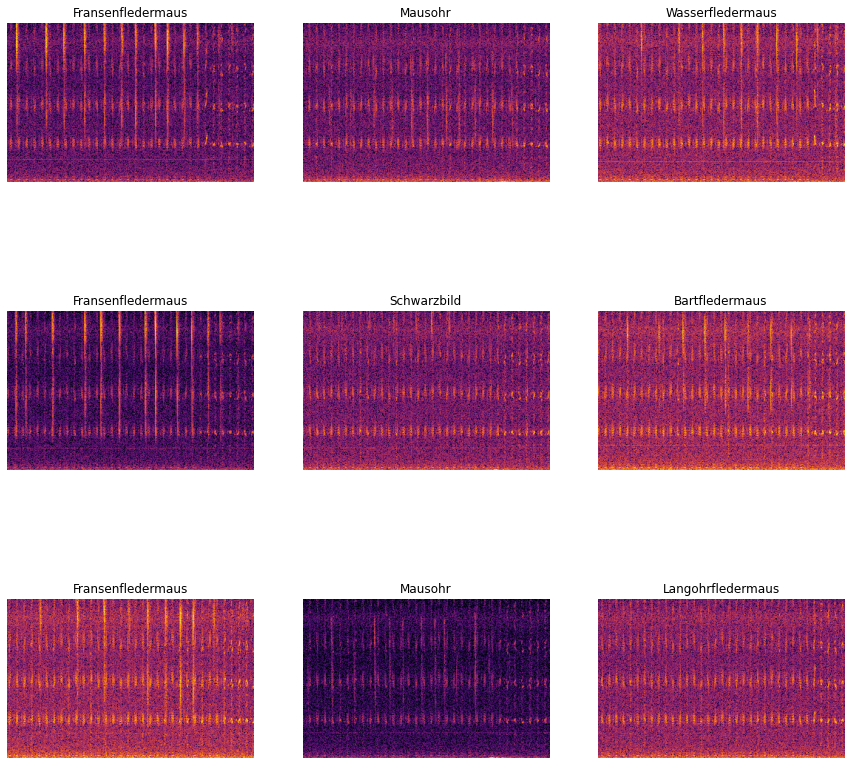

In [264]:
plt.figure(figsize=(15, 15))
for images, labels in train_ds.take(1):

  for i in range(9):
    index = tf.argmax(labels[i], axis=0)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[index.numpy()])
    plt.axis("off")

### Input shape

In [265]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(64, 216, 334, 3)
(64, 8)


## Models

### Preparations

Configure the dataset for performance, see: https://www.tensorflow.org/tutorials/images/classification#configure_the_dataset_for_performance

In [266]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

The RGB channel values are in the [0, 255] range. 
Here, we will standardize values to be in the [0, 1] range by using tf.keras.layers.Rescaling:

In [267]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

An example:
(Later we will use the Rescaling directly in our model.)

In [268]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

0.0 0.98823535


### First Simple Model

In [269]:
model = keras.Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(32,                      
                  kernel_size=(3,3),         
                  strides=(1,1),            
                  padding='same',            
                  activation='relu'),
  layers.MaxPooling2D(),
    
  layers.Conv2D(64,                      
                  kernel_size=(3,3),         
                  strides=(1,1),            
                  padding='same',            
                  activation='relu'),
  layers.MaxPooling2D(),
    
  layers.Conv2D(128,                      
                  kernel_size=(3,3),         
                  strides=(1,1),            
                  padding='same',            
                  activation='relu'),
  layers.MaxPooling2D(),
  
  layers.Flatten(),
    
  layers.Dropout(0.05),
    
  layers.Dense(160, 
               kernel_regularizer=keras.regularizers.l2(0.001), 
               bias_regularizer=keras.regularizers.l2(0.001), 
               activation='relu'),
  
  layers.Dense(len(class_names), activation='softmax')
])

In [270]:
adamOptimizer=keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False)


model.compile(optimizer=adamOptimizer,
      loss='categorical_crossentropy',
      metrics=['accuracy'])

In [271]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 216, 334, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 216, 334, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 108, 167, 32)     0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 108, 167, 64)      18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 54, 83, 64)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 54, 83, 128)      

Before we fit our model, we add twoi more things: **early stopping** and a **scheduler** for the **learning rate**.

Early stopping:

In [272]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

Scheduler for dynamic learning rate:

In [273]:
start_lr = 0.0001
exp_decay = 0.1

# exponential scheduling for learning rate
def scheduler(epoch):
  def lr(epoch, start_lr, exp_decay):
    return start_lr * math.exp(-exp_decay*epoch)
  return lr(epoch, start_lr, exp_decay)

scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)

Fit the model:

In [274]:
epochs=40
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[stop_early, scheduler]
)

Epoch 1/40


2022-06-21 11:13:27.295371: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


21/21 [==============================] - ETA: 0s - loss: 1.9158 - accuracy: 0.4479

2022-06-21 11:13:35.979791: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


21/21 [==============================] - 10s 362ms/step - loss: 1.9158 - accuracy: 0.4479 - val_loss: 1.7787 - val_accuracy: 0.5105 - lr: 1.0000e-04
Epoch 2/40
21/21 [==============================] - 7s 354ms/step - loss: 1.7035 - accuracy: 0.4936 - val_loss: 1.6950 - val_accuracy: 0.4925 - lr: 9.0484e-05
Epoch 3/40
21/21 [==============================] - 8s 362ms/step - loss: 1.5749 - accuracy: 0.5139 - val_loss: 1.6038 - val_accuracy: 0.5285 - lr: 8.1873e-05
Epoch 4/40
21/21 [==============================] - 7s 358ms/step - loss: 1.4547 - accuracy: 0.5790 - val_loss: 1.4504 - val_accuracy: 0.5826 - lr: 7.4082e-05
Epoch 5/40
21/21 [==============================] - 7s 356ms/step - loss: 1.3161 - accuracy: 0.6315 - val_loss: 1.3730 - val_accuracy: 0.6607 - lr: 6.7032e-05
Epoch 6/40
21/21 [==============================] - 8s 361ms/step - loss: 1.1644 - accuracy: 0.6974 - val_loss: 1.2674 - val_accuracy: 0.7087 - lr: 6.0653e-05
Epoch 7/40
21/21 [==============================] - 8s 3

In [275]:
model.evaluate(val_ds)

6/6 [==============================] - 1s 135ms/step - loss: 1.0323 - accuracy: 0.7508


[1.0323423147201538, 0.7507507801055908]

Text(0.5, 1.0, 'Learning Rate (Exponential)')

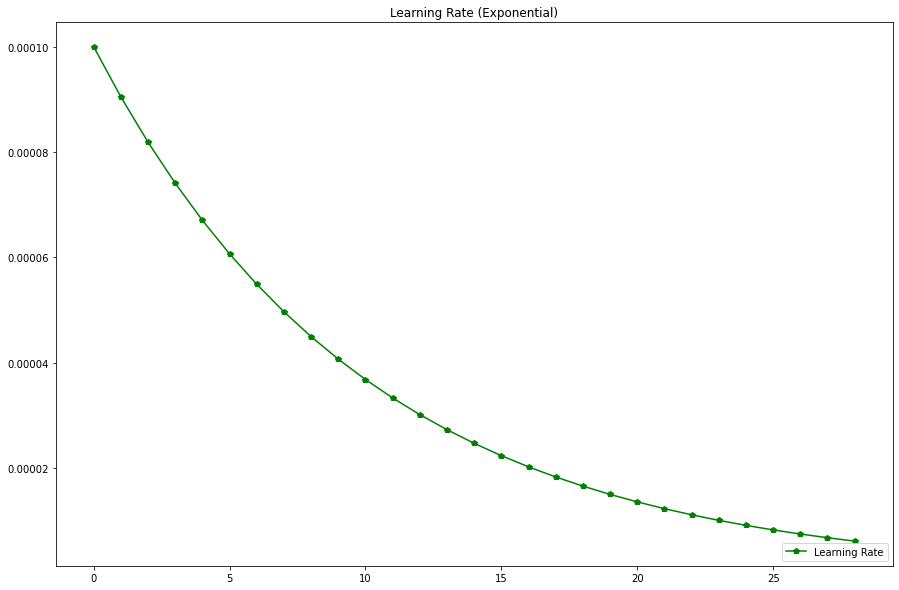

In [276]:
lr = history.history['lr']

plt.figure(figsize=(15, 10))
plt.plot(range(len(lr)), lr, label='Learning Rate', marker='p', color='g')
plt.legend(loc='lower right')
plt.title('Learning Rate (Exponential)')

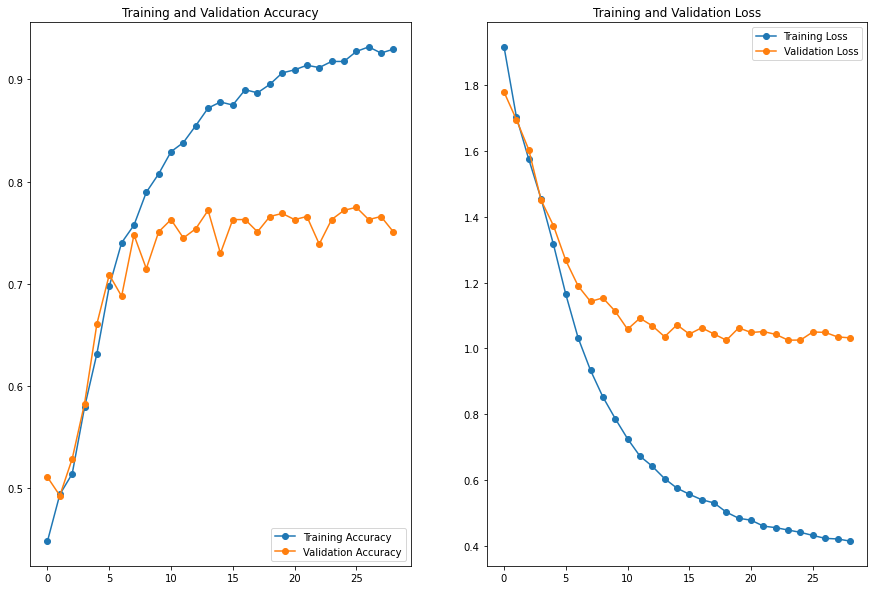

In [277]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

# Does not work because of early stopping
# epochs_range = range(epochs)
# Compute range of epochs out of model hsitory data

epochs_range = range(len(loss))

plot_model_loss_acc(epochs_range=epochs_range, acc=acc, val_acc=val_acc, loss=loss, val_loss=val_loss) 

1/6 [====>.........................] - ETA: 1s

2022-06-21 11:17:25.580815: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 1s 105ms/step


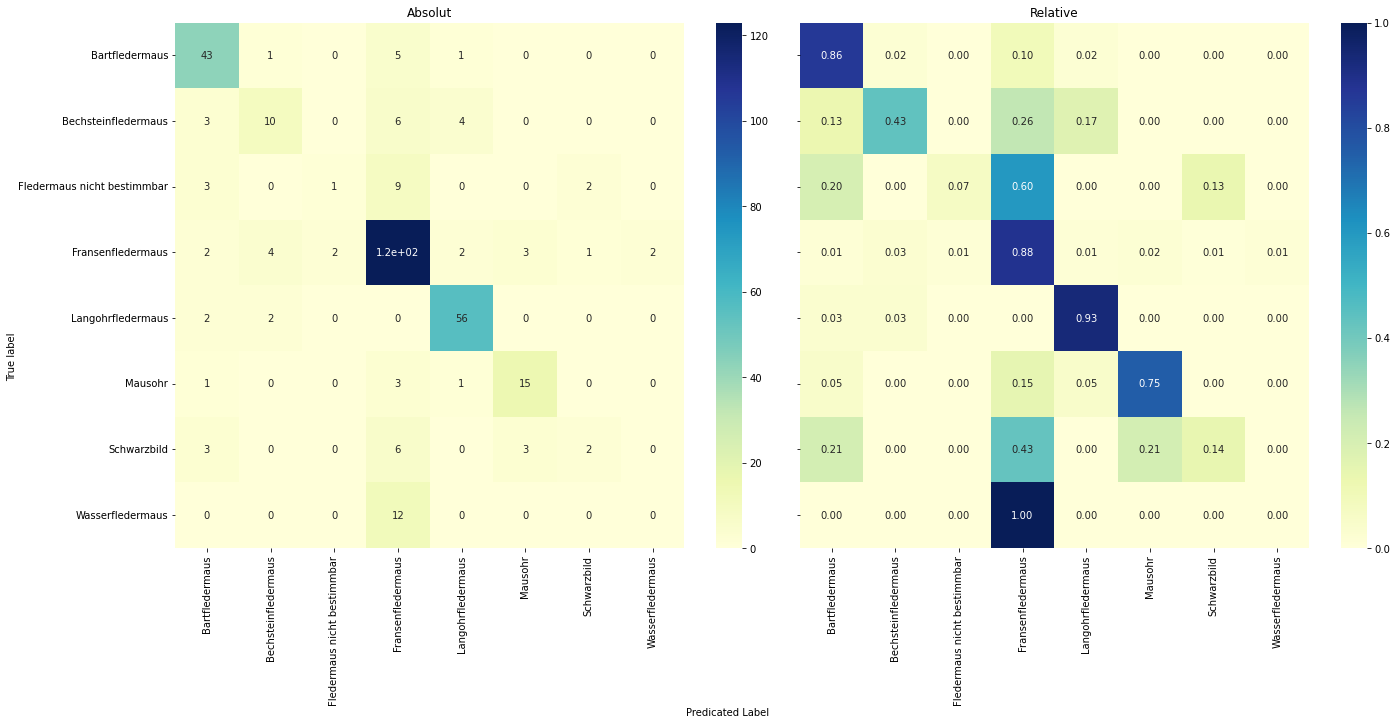

In [278]:
y_pred = model.predict(val_ds)
y_true = np.concatenate([y for x, y in val_ds], axis=0)

cm = confusion_matrix(y_true=np.argmax(y_true, axis=-1), y_pred=np.argmax(y_pred, axis=-1))
    
plot_confusion_matrix(cm=cm, classes=class_names)


### Enhancement with Data Augmentation

In [58]:
with tf.device('/cpu:0'):
    data_augmentation = keras.Sequential(
      [
        layers.RandomFlip("horizontal",
                          input_shape=(img_height,
                                      img_width,
                                      3)),
        layers.RandomRotation(0.2),
        layers.RandomZoom(0.2),
      ]
    )

model_da = keras.Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(30,                      
                  kernel_size=(3,3),         
                  strides=(1,1),            
                  padding='same',            
                  activation='relu'),
  layers.MaxPooling2D(),
    
  layers.Conv2D(60,                      
                  kernel_size=(3,3),         
                  strides=(1,1),            
                  padding='same',            
                  activation='relu'),
  layers.MaxPooling2D(),
    
  layers.Conv2D(90,                      
                  kernel_size=(3,3),         
                  strides=(1,1),            
                  padding='same',            
                  activation='relu'),
  layers.MaxPooling2D(),
  
  layers.Flatten(),
  layers.Dropout(0.05),
  layers.Dense(160, activation='relu'),
  layers.Dense(len(class_names), activation='softmax')
])

In [59]:
adamOptimizer = adamOptimizer=keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False)
model_da.compile(optimizer=adamOptimizer,
      loss='categorical_crossentropy',
      metrics=['accuracy'])

In [60]:
model_da.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 288, 432, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 288, 432, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 288, 432, 30)      840       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 144, 216, 30)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 144, 216, 60)      16260     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 72, 108, 60)      0         
 2D)                                                  

In [68]:
epochs=40
history_da = model_da.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/40
14/14 [==============================] - 22s 1s/step - loss: 1.4379 - accuracy: 0.4920 - val_loss: 1.4613 - val_accuracy: 0.5207
Epoch 2/40
14/14 [==============================] - 23s 2s/step - loss: 1.4406 - accuracy: 0.5161 - val_loss: 1.3454 - val_accuracy: 0.5161
Epoch 3/40
14/14 [==============================] - 24s 2s/step - loss: 1.3753 - accuracy: 0.5229 - val_loss: 1.4437 - val_accuracy: 0.5207
Epoch 4/40
14/14 [==============================] - 23s 2s/step - loss: 1.3589 - accuracy: 0.5505 - val_loss: 1.3185 - val_accuracy: 0.5945
Epoch 5/40
14/14 [==============================] - 25s 2s/step - loss: 1.3385 - accuracy: 0.5321 - val_loss: 1.2733 - val_accuracy: 0.5484
Epoch 6/40
14/14 [==============================] - 22s 2s/step - loss: 1.2668 - accuracy: 0.5677 - val_loss: 1.2871 - val_accuracy: 0.5346
Epoch 7/40
14/14 [==============================] - 21s 2s/step - loss: 1.2780 - accuracy: 0.5860 - val_loss: 1.3663 - val_accuracy: 0.5438
Epoch 8/40
14/14 [==

In [69]:
model_da.evaluate(val_ds)

4/4 [==============================] - 1s 179ms/step - loss: 1.2255 - accuracy: 0.7235


[1.2254598140716553, 0.7235022783279419]

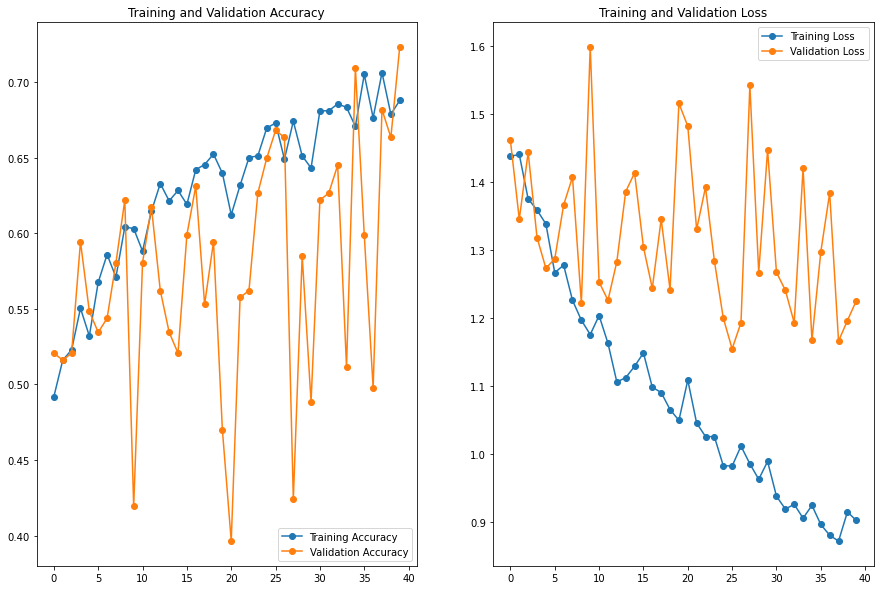

In [70]:
acc = history_da.history['accuracy']
val_acc = history_da.history['val_accuracy']

loss = history_da.history['loss']
val_loss = history_da.history['val_loss']

epochs_range = range(epochs)

plot_model_loss_acc(epochs_range=range(epochs), acc=acc, val_acc=val_acc, loss=loss, val_loss=val_loss) 

4/4 [==============================] - 1s 239ms/step


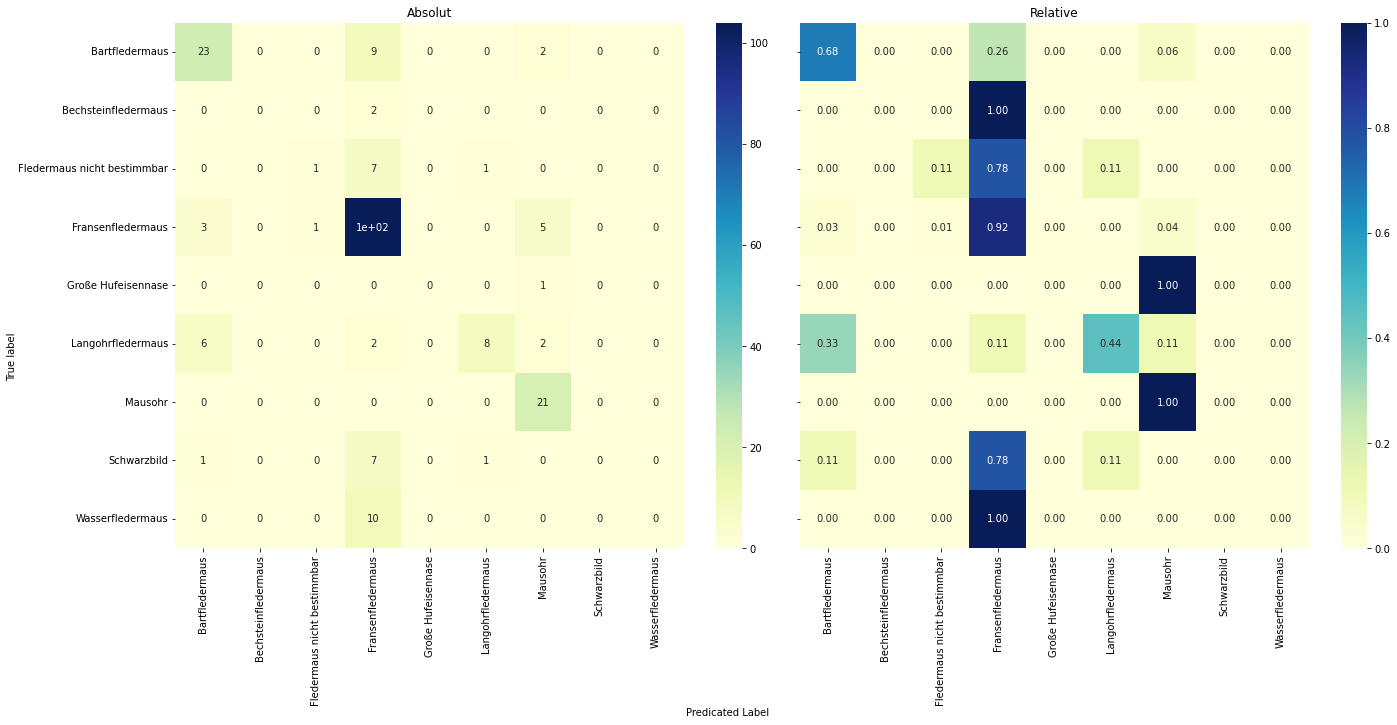

In [72]:
y_pred = model_da.predict(val_ds)
y_true = np.concatenate([y for x, y in val_ds], axis=0)

cm = confusion_matrix(y_true=np.argmax(y_true, axis=-1), y_pred=np.argmax(y_pred, axis=-1))
    
plot_confusion_matrix(cm=cm, classes=class_names)

## Keras Parameter Tuning

In [225]:
def model_builder(hp):
    model_to_train = keras.Sequential([
      layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
      layers.Conv2D(32,                      
                      kernel_size=(3,3),         
                      strides=(1,1),            
                      padding='same',            
                      activation='relu'),
      layers.MaxPooling2D(),

      layers.Conv2D(64,                      
                      kernel_size=(3,3),         
                      strides=(1,1),            
                      padding='same',            
                      activation='relu'),
      layers.MaxPooling2D(),

      layers.Conv2D(128,                      
                      kernel_size=(3,3),         
                      strides=(1,1),            
                      padding='same',            
                      activation='relu'),
      layers.MaxPooling2D(),

      layers.Flatten(),
      layers.Dropout(0.05)
    ])
  
    # Tune the number of units in the first Dense layer
    # Choose an optimal value between 32-512
    hp_units = hp.Int('units', min_value=32, max_value=512, step=32) 
    model_to_train.add(keras.layers.Dense(units=hp_units, kernel_regularizer=keras.regularizers.l2(0.001), 
               bias_regularizer=keras.regularizers.l2(0.001), activation='relu'))
    model_to_train.add(keras.layers.Dense(len(class_names), activation='softmax'))

    # Tune the learning rate for the optimizer
    # Choose an optimal value from 0.01, 0.001, or 0.0001
    # hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    model_to_train.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001),
                loss='categorical_crossentropy',
                metrics=['accuracy'])
    
    return model

In [226]:
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=20,
                     factor=3,
                     directory='my_dir',
                     project_name='bats_opti')

In [227]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [228]:
tuner.search(x=train_ds, epochs=25, validation_data=val_ds, callbacks=[stop_early, scheduler])

Trial 17 Complete [00h 01m 13s]
val_accuracy: 0.7485030293464661

Best val_accuracy So Far: 0.7694610953330994
Total elapsed time: 00h 08m 44s

Search: Running Trial #18

Value             |Best Value So Far |Hyperparameter
320               |192               |units
20                |3                 |tuner/epochs
7                 |0                 |tuner/initial_epoch
2                 |2                 |tuner/bracket
2                 |0                 |tuner/round
0014              |None              |tuner/trial_id

Epoch 8/20


2022-06-21 11:04:44.749608: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


21/21 [==============================] - ETA: 0s - loss: 0.1445 - accuracy: 0.9843

2022-06-21 11:04:51.910582: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


21/21 [==============================] - 9s 411ms/step - loss: 0.1445 - accuracy: 0.9843 - val_loss: 1.6917 - val_accuracy: 0.6737 - lr: 4.9659e-05
Epoch 9/20
21/21 [==============================] - 9s 418ms/step - loss: 0.1222 - accuracy: 0.9940 - val_loss: 1.6032 - val_accuracy: 0.7485 - lr: 4.4933e-05
Epoch 10/20
21/21 [==============================] - 9s 417ms/step - loss: 0.1073 - accuracy: 0.9985 - val_loss: 1.6502 - val_accuracy: 0.7545 - lr: 4.0657e-05
Epoch 11/20
21/21 [==============================] - 8s 365ms/step - loss: 0.0990 - accuracy: 1.0000 - val_loss: 1.6213 - val_accuracy: 0.7515 - lr: 3.6788e-05
Epoch 12/20
21/21 [==============================] - 8s 375ms/step - loss: 0.0954 - accuracy: 1.0000 - val_loss: 1.5911 - val_accuracy: 0.7395 - lr: 3.3287e-05
Epoch 13/20
21/21 [==============================] - 9s 431ms/step - loss: 0.0941 - accuracy: 1.0000 - val_loss: 1.6106 - val_accuracy: 0.7455 - lr: 3.0119e-05
Epoch 14/20
11/21 [==============>...............] - 

KeyboardInterrupt: 

Get the optimal hyperparameters

In [78]:
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")


The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 160 and the optimal learning rate for the optimizer
is 0.0001.



Build the model with the optimal hyperparameters and train it on the data for 50 epochs

In [84]:
model = tuner.hypermodel.build(best_hps)
history = model.fit(x=train_ds, validation_data=val_ds, epochs=50)

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Epoch 1/50


2022-06-15 20:09:56.860151: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


14/14 [==============================] - ETA: 0s - loss: 1.8917 - accuracy: 0.3830

2022-06-15 20:10:07.546438: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


14/14 [==============================] - 13s 821ms/step - loss: 1.8917 - accuracy: 0.3830 - val_loss: 1.6384 - val_accuracy: 0.4378
Epoch 2/50
14/14 [==============================] - 11s 740ms/step - loss: 1.6051 - accuracy: 0.4759 - val_loss: 1.5898 - val_accuracy: 0.4332
Epoch 3/50
14/14 [==============================] - 11s 761ms/step - loss: 1.5415 - accuracy: 0.4759 - val_loss: 1.5402 - val_accuracy: 0.4378
Epoch 4/50
14/14 [==============================] - 10s 710ms/step - loss: 1.4980 - accuracy: 0.4828 - val_loss: 1.5466 - val_accuracy: 0.4608
Epoch 5/50
14/14 [==============================] - 10s 733ms/step - loss: 1.4608 - accuracy: 0.4954 - val_loss: 1.4943 - val_accuracy: 0.4516
Epoch 6/50
14/14 [==============================] - 10s 727ms/step - loss: 1.4089 - accuracy: 0.5126 - val_loss: 1.4700 - val_accuracy: 0.4608
Epoch 7/50
14/14 [==============================] - 11s 741ms/step - loss: 1.3965 - accuracy: 0.5080 - val_loss: 1.4576 - val_accuracy: 0.5115
Epoch 8/50